Run this cell if any new reqiurements have been installed, this will update *requirements.txt* in the working directory

In [21]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


Just run the cell below to install all the requirements for this project (If `conda` doesnt work try replacing it with `pip`).

In [ ]:
%conda install -r requirements.txt

# Convolutional Neural Network for Blocking Prediction

In this notebook we perform the Deep Learning algorithm training on the geopotential height anomaly contours ( $ \textrm{Z500}^{*} $ in the report). We use the $ \textrm{Z500}^{*} $ daily mean contours ( $ 1^{ \circ } \times 1^{ \circ } $ spatial resolution ) from the ERA5 reanalysis dataset fromt the European Center of Medium-Range Weather Forecasts, <cite data-cite="p19027"></cite>. Initially the European domain was defined to have $ 75^{\circ} \textrm{N} - 30^{\circ} \textrm{N} $ latitudinal range and the $ 10^{ \circ } \textrm{W} - 40^{\circ} \textrm{E}$ range of longitudes, taking the zero longitude to be the Greenwich meridian. The $ \textrm{Z500}^{*} $ was defined by the departures from the Long Term Daily Mean (LTDM), which was calculated for each grid cell as described in Pinheiro et al 2019. Total amount of data used consisted of 40 92-day summer periods (June-July-August) from 1st of June 1979 - 31st of August 2018 were used.



In [16]:
# load usual python packages
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time


# for reading and displaying images
#from skimage.io import imread
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point


# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# load packages for progress visualisation
from tqdm import tqdm

# load pytorch packages for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD


import xarray
import netCDF4
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import sys
import numpy
import math
#numpy.set_printoptions(threshold=sys.maxsize)

#import custom functions
import Utils_for_CNN
from Utils_for_CNN import check_blocking_accuracy
from Utils_for_CNN import windowing_geopotential_new
from Utils_for_CNN import format_labeling
from Utils_for_CNN import multiply_data

date_today = datetime.now().strftime("%Y-%m-%d")

The cell below is for establishing autorelaod of the *Utils_for_CNN.py* file that contains the neccesary functions for the CNN.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

We use ERA5 reanalysis data which includes: 500hPa geopotential height contours, $ \textrm{Z500} $, (used for TM90 method), geopotential height anomaly contours,$ \textrm{Z500}^* $, (used for DG83 method) and 300 K isentropic potential vorticity contours, (used for S04 index). Here is an example of the $ \textrm{Z500} $ and $ \textrm{Z500}^* $ contours and their respective labeling dated 01/06/1979 (left column) and 21/08/1979 (right column):
<img src="TM90_and_DG83_bigger_cap.png">

**NOTE: *Please change the paths to the files on your computer*.** One of the data files requires the presence of *Results\_table\_ddmmyy.csv* in the current working directory. Make sure to change the `date_of_last_saved` to the date indicated on the csv file.

**This project was started before the reanalysis data for 2019 has come out. As a result the analysis was only performed on the 40 summer periods from 1979 to 2018 inclusive, giving exactly 3680 summer days (92 days per summer period). As time goes by more and more data will become available and the analysis performed in this notebook can be easily adapted to more data. PLEASE SET THE TIME DOMAIN USING `time_domain_size` DEPENDING ON THE INTENDED INVESTIGATION. Make sure that all files with indices also have the same time domain size (e.g. TM90, DG83, S04 and GTD) as their recalculation will likely be required.**

In [17]:
#defining constants and loading data (change paths for your computer)
g=9.80665
time_domain_size = int(3680) #for 40 92-day summer periods
years = 40
days_per_year = 92

""" Loading the geopotential height and potential vorticity ERA5 Reanalysis datasets """

#change the date of last saved to access the CNN performance tracking data
date_of_last_saved = '2020-04-17'
performance_analysis = pd.read_csv('Results_tables/Results_table_' + date_of_last_saved)

#files of calculated indices (only the 'combined' one required for the algorithm, 
#it will be later replaced with the Grand Truth Dataset)
DG83 = np.loadtxt('DG83_LTDMcorr_blocking_idx_050220.txt')
TM90 = np.loadtxt("TM90_daymean_blocking_idx_050220.txt")
S04 = np.loadtxt("S04_LTDMcorr_blocking_idx_050220.txt")
#combined = np.loadtxt("TM90_DG83_S04_combined.txt")
GTD = np.loadtxt("Grand_Truth_DataSet_Vic_Peer_Joe_Michaela_Carl_070320.txt")

comparing_idx = pd.DataFrame(TM90[0:time_domain_size], columns = ['Mine_TM90'])
comparing_idx['S04'] = S04[:time_domain_size]
comparing_idx['DG83'] = DG83[:time_domain_size]

comparing_idx['all_three_agree']  = ( (comparing_idx['Mine_TM90'] == 1) & (comparing_idx['S04'] == 1)
                                     & (comparing_idx['DG83'] == 1) )*1

#printing initial statistics of the method specific labeling
print("Total Blocked Days, DG83: {}, S04: {}, TM90: {}, GTD_filtered: {}".format(DG83.sum(),S04.sum(),TM90.sum()\
                                                                                 , GTD.sum()))
print("All indices (TM90, DG83 and S04) agree and are labeled 1 on {} days".format(comparing_idx['all_three_agree'].sum()))

Total Blocked Days, DG83: 489.0, S04: 244.0, TM90: 263.0, GTD_filtered: 600.0
All indices (TM90, DG83 and S04) agree and are labeled 1 on 3 days


The Groung Truth Dataset and TM90, DG83 and S04 method indices are shown below <img src="GTD.png"> <img src="all_indices.png">


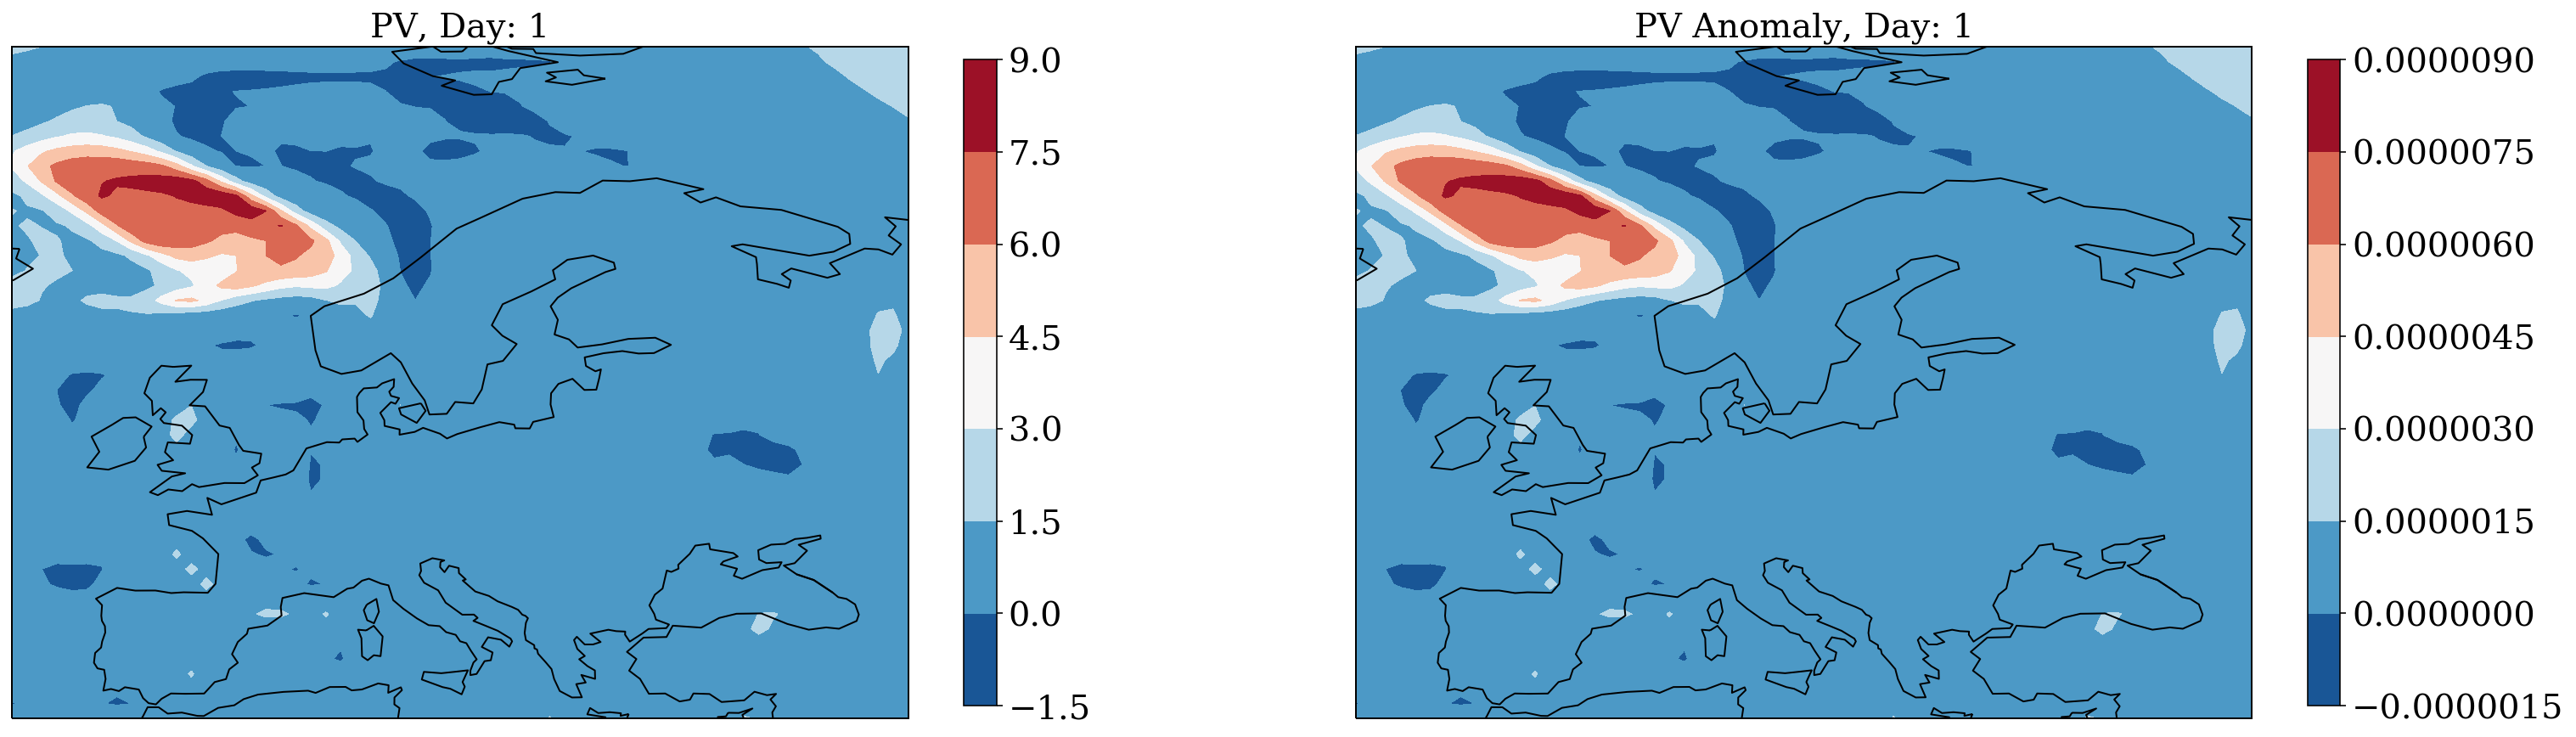

In [13]:
# visualising the geopotential height plots for algorithm training
# NOTE: these plots have low contracts and the blocking structure present on these plots are hard to identify by eye
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 20, # fontsize for x and y labels (was 10)
    'axes.titlesize': 20,
    'font.size': 20, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.figsize': [26, 28],
    'font.family': 'serif',
}

matplotlib.rcParams.update(params)

day=1
PVU_thresh = 1.5
levels = np.arange(-PVU_thresh, PVU_thresh+0.3, 0.3)

fig = plt.figure(figsize=(26,28))
ax1 = fig.add_subplot(1,2, 1,projection=ccrs.PlateCarree())
#ax1 = fig.add_subplot(121)
ax1.set_aspect(1.0)
ax1.set_title("PV, Day: {}".format(day))
ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
im1 = ax1.contourf(np.array(pv_file['longitude']),np.array(pv_file['latitude']),pv_file[day]*1e6,cmap='RdBu_r')#, levels=levels)
#im3 = ax1.contourf(np.array(pv_file['longitude']),np.array(pv_file['latitude']),pv_file[1]) 
fig.colorbar(im1,ax=ax1,shrink=0.25)

ax2 = fig.add_subplot(1,2, 2,projection=ccrs.PlateCarree())
ax2.set_aspect(1.0)
ax2.add_feature(cfeature.COASTLINE, edgecolor='black')
ax2.set_title("PV Anomaly, Day: {}".format(day))
im2 = ax2.contourf(np.array(pv_file['longitude']),np.array(pv_file['latitude']),pv_file[day],cmap='RdBu_r')
#im3 = ax1.contourf(np.array(pv_file['longitude']),np.array(pv_file['latitude']),pv_file[1]) 
fig.colorbar(im2,ax=ax2,shrink=0.25)

#plt.savefig("pv_plots.png", dpi=150)
plt.show()


### Choosing the data for training

We have a couple of different files available for us from Carl. The `zg_file` is the RAW geopotential height data, the `zg_dtrnd_file` is the geopotential height anomaly detrended with respect to climate change and the `zg_dtrnd_norm_file` is the geopotential height anomaly detrended wrt climate change AND normalised latitudinally as explained in calculations for DG83. We also make the use of the calculation of the standart deviation of anomalies of the geopotential height calculated over 26 years, `var_anom_thresh_arr` (as described in Pinheiro 2019).  

**Choose ONE *file_name* depending on what data you want to train the CNN (comvolutional neural network)** 

In [14]:
#choose ONE file_name for training the CNN and the name extension for saving the plots

#the name variable is useed for file names when saving progress and output data 
#name = '500zg_JJA_era5_1979-2018_0000_EurAR5_'
#name = '500zg_JJA_era5_1979-2018_0000_EurAR5_anom_dtrnd_wrt_tas_'
#name = '500zg_JJA_era5_1979-2018_0000_EurAR5_anom_dtrnd_wrt_tas_normDG83_'
#name = '500zg_JJA_era5_1979-2019_3hr_1x1_'
#name = '500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas'
name = 'pv_300pt_era5_1979-2019_1x1_0000_JJA_Eurplus5'

#this used for training 
#file_name = zg_file
#file_name = zg_dtrnd_file
#file_name = zg_dtrnd_norm_file_lowres 
#file_name = zg_dtrnd_norm_anom_1x1_2019
file_name = pv_file
#file_name = pv_anom_file

## Preprocessing data for training, defining hyper-parameters and the model (i.e. CNN) 

The data needs to be pre-proccessed before training. 

 - Firstly, the window method should be applied which stacks several days worth of data into a single sample. This ensures the understanding and implementation of the overlap and persistence criteria by the algorithms during learning. Our input consists of three things: 1) the images of geopotential height (or its anomaly depending what `file_name` is set to), 2) their respective dates and 3) the Grand Truth Dataset, which labels the images. The window method needs to be applied to each of the three inputs before resampling can be performed. An example of a 7-day window sample is shown below.
<img src="window_method.png">
 - Secondly, due to the imbalanced dataset problem we need to either upsample the minority class (the blocked days) or downsample the majority class (the non-blocked days). This is done by using the`sklearn.utils` function called `resample()`. **NOTE:** `resample()` function does not neccesseraly uses all original days for resampling (i.e. it can use 997 dates out of 1000 due to the randomisation of the resampling). This can cause issues when analysing the output labels and resampling back to the original number of samples. Tracking of the samples used by the algorithm is done by keeping record of the dates. For the 7-day window samples are transformed into a `pandas.DataFrame` and are merged with the labels and the dates. After the resampling is applied, the labels and the dates are disjoined from the rest of the features.  
 - Finally, before we split the data into train and test subsets we want to make it as easy as possible for the algorithm to distinguish trends from the features. The data needs to be scaled so that all the features are valued in the same range of numbers (i.e. we do not have one feature ranging between 1 and 5 and another fluctuating between 100 and 10000). However, we would like to keep the trends within data unperturbed by the scailing. We use `sklearn.preprocessing` function called `MinMaxScaler()` which preserves the shape of the original distribution and thus does not change the information stored in the original data https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 . 

We then use labeling X to identify features (2D with dimensions (time: 3440 7-day window samples, features: 7 2D images stacked along y-axis)) and Y to identify the labels (1D, 3400 labels). More in detail explanation of every pre-processing step can be found in the report.



**NOTE: define the hyper-parameters your CNN below:**
 - `number_classes` (int): number of possible output labels (default = 2, for blocked and non-blocked) 
 - `window_method` (boolean): True or False, set to True to apply the overlap and persistence criteria
 - `window_period` (int): number of days for stacking 
 - `label_day` (int): the position of the day in the window which is used for labeling the whole sample. Chosen such that the labeling day is the middle day in the sample window (e.g. 4th for a 7-day window sample)

In [20]:
%%time 

# define hyper-parameters
number_classes = 2
window_method = True
window_period = 7
label_day = 4

dates = np.array(file_name[:time_domain_size].time)

#stacking 7 days together and using it as one training example
#if not used set window_methode = False
#if file_name is longer than 3680, need to slice array 
#need to remove 4 (or however many days we deside to window for )

#applying the window method 
file_split = np.array(file_name[:time_domain_size]).reshape(years,days_per_year,file_name.shape[1],file_name.shape[2])
persistency_applied =[]
for i in range(len(file_split)):
    persistency_applied.append(windowing_geopotential_new(file_split[i],window_period))

#aplication of window method to the labeling and the dates arrays (also need to lose 4 days at the beginning)
if window_method:
    file_name_ = np.array(persistency_applied).reshape(file_split.shape[0]*(file_split.shape[1]-(window_period-1)),
                                                       file_split.shape[2],file_split.shape[3]*window_period)
    combined_ = format_labeling(GTD[:time_domain_size],window_period,label_day,years, days_per_year)
    formated_dates = format_labeling(dates, window_period,label_day, years, days_per_year)

# this is for when we have more than one snapshot in a day
# this does not yet work with windowing (NOTE all analysis was performed on daily mean contours)
if name == '500zg_JJA_era5_1979-2019_3hr_1x1_':
    cut = 29440
    multiplier = 8
    dimlat = 41
    dimlon = 51
else:
    cut = time_domain_size
    multiplier = 1
    dimlat = 181
    dimlon = 201

#change to True if masked file is used (line above)
ismasked = False
label = 'GTD_filtered'

#splitting the blocked and non blocked cases for data upsampling
# first need to combine the labels and the feature data
full_data = pd.DataFrame(file_name_.reshape(file_name_.shape[0],file_name_.shape[1]*file_name_.shape[2]))
full_data['label'] = combined_.astype(int)
full_data['date'] = formated_dates
full_data['date'] = full_data['date'].dt.date

#splitting into majority and minority classes
data_minority = full_data[full_data['label']==1]
data_majority = full_data[full_data['label']==0]

#choose whether to upsample minority class or downsample majority class
#uncomment relevant lines below
min_upsampling = True
maj_downsampling = False

data_minority_upsampled = resample(data_minority, replace = True, n_samples = len(data_majority))
#data_majority_downsampled = resample(data_majority, replace = True, n_samples = len(data_minority), random_state = 123)

data_upsampled = pd.concat([data_majority,data_minority_upsampled]).sort_index(axis = 0)
#data_upsampled = pd.concat([data_minority, data_majority_downsampled]).sort_index(axis = 0)

#split it back to features, labels and dates. Apply the feature scailing:
sc = MinMaxScaler()

upsampled_X = sc.fit_transform(data_upsampled.iloc[:,:-2])
upsampled_Y = np.array(data_upsampled.iloc[:,-2])
dates_upsampled = data_upsampled.iloc[:,-1]

# making a dataset (need to reshape the array so it fits the PyTorch requirments)
X = upsampled_X.reshape(len(upsampled_X), 1, file_name_.shape[1], file_name_.shape[2])
Y = upsampled_Y #.reshape(len(upsampled_Y),1)


CPU times: user 28.5 s, sys: 2.47 s, total: 30.9 s
Wall time: 22.5 s


### Choosing the CNN's internal architecture

The structure of CNN can be quite diverse and there can be an infinitely large number of degrees of freedom that you can play with. CNN has been chosen for this project due to its ability to to recognise patterns independently of their position in an image (src: Bengio Y, Courville A, Goodfellow IJ. Deep learning: adaptive computation and machine
learning. Bengio A Courville. 2016.). It does so by using a combination of convolutional and linear layers. In this project we used 2 convolutional layers, 2 Max pooling layers and 2 linear layers. A good visualisation of the structure of the CNN is shown below. **NOTE: instead of the input image shown in figure a 7-day window sample was used in this project**. For more information about the CNN's structure see https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb and the relevant reference mentioned in the report.
<img src="Cnn_structure.png">

In [12]:
#define your network
class Blocking_Net(nn.Module):
    def __init__(self, class_no ):
        super(Blocking_Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 6, 5), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, 1))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,1))
        
        self.fc1 = nn.Sequential(nn.Linear(4160, 4), nn.ReLU(inplace=True))
        self.fc2 = nn.Linear(4, class_no)

    def forward(self, input):
        output = self.conv1(input)  #x = self.pool(F.relu(self.conv1(x)))
        output = self.pool(output)
        output = self.conv2(output)  #x = self.pool(F.relu(self.conv2(x)))
        output = self.pool2(output)
        #output = self.conv3(output)
        #print ('2d: {}'.format(output.size()))
        output = output.view(output.size(0),-1) #view(-1, 16*5*5)
        #print ('1d: {}'.format(output.size()))
        output = self.fc1(output)
        output = self.fc2(output)
        
        return output


## Algorithm's Trainign and Testing

Here we begin training the algorithm for Blocking detection. The next cell runs the CNN once and the cross-validation technique is applied. This code is good to use for a quick trial and error approach to hyper-parameter tunning and testing. As mentioned above, the resampling of the class samples is random. Thus, in order to understand how the performance of the algorithm changes with variation of a specific hyper-parameter a full algorithmic run should be used (the one that keep the data sampling constant, see report for more discussion on that). In order to set the algorithm training a couple of parameters need to be chosen first:
 - `kfolds` (int): number of Cross-Validation folds (or subsets of data) that is needed for Cross Validation. A shematic of a Cross-Validation Process is shown below and more information is available from: https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,k%2Dfold%20cross%2Dvalidation. We chose kfold=3.
 - `b_size` (int): the batch size is defined as the amount of samples algorithm looks at at one time (or processes before updating the loss parameters), chosen to be 200.
 - `number_of_epoch` (int): the number of epoch is defined as the number of times the algorithms looks through the whole data, chosen to be 40. 
These are static hyperparameter that are fixed throught learning. Now we look at the dynamic hyoer-parameter that can be chaged during the algorithm's training to aid better learning:
 - `learn_rate` (float): the learning rate defines the speed at which the model updates its coefficients. If the value is too large it can overshoot the global minimum, and if it is too small and the algorithm will take a long time to converge. This parameter can therefore be chose to change throught learning (e.g. to become smaller and smaller, exponentially decaying, etc.) which has a potential to improve algorithm's learning. Static learning rate has been used throught this project. More info can be found at: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1 .
 - `mom` (int): momentum, it is used to help reach the global minima of the loss function faster thus speeding up the learning. It is also good for overshooting local minimas in complex gradient profiles of the loss function. Varying the momentum value between epoches can thus boost algorithm performance even further. Static momentum value has been used in this project. It is an advanced machine learning technique and more information can be found on: https://medium.com/@abhinav.mahapatra10/ml-advanced-momentum-in-machine-learning-what-is-nesterov-momentum-ad37ce1935fc .
<img src="Cross_validation.png">
These are far not all hyper-parameters that a Neural Network uses but theose parameters are the basic parameters that are commonly used for machine learning algorithms. Further for our CNN the loss function and the optimizer function have to be chosen. 
 - Cross Entropy Loss is often used for both binary and multi-label classification tasks as opposed to the Mean Squared Error loss which is better suited for a regression type problem. The predicted label is also penalised based on its distance from the expected value (i.e. a 1 or a 0). This penalty is logarithmic and has a small value if the difference is small. More on on Cross Entropy Loss can be found: https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/ .
 - SGD optimiser was used for this project as it is able to perform the parameter updated on-the-fly for each training sample. Its objective fuction has high variance. Similarly to momentum parameter it is able to jump out from a local minima to a better one due to this high fluctuation. It is said to be better used with a decreasing learning rate, more information can be found here: https://ruder.io/optimizing-gradient-descent/#:~:text=Stochastic%20gradient%20descent,-Stochastic%20gradient%20descent&text=Batch%20gradient%20descent%20performs%20redundant,examples%20before%20each%20parameter%20update.&text=SGD%20performs%20frequent%20updates%20with,heavily%20as%20in%20Image%201.

In [13]:
%%time
#chose the ratio of train test split (3:1 is used)
X_train, X_test = train_test_split(X,test_size=0.25,shuffle=False)
Y_train, Y_test = train_test_split(Y,test_size=0.25,shuffle=False)
dates_train, dates_test = train_test_split(dates_upsampled,test_size=0.25,shuffle=False)
test_dates = dates_test.reset_index()['date']

#Choose hyper-parameters
kfolds = 3 # Number of K-fold Splits
b_size = 200
number_of_epoch = 40

# dynamic hyper-parameters (i.e. can be changed throught learning to aid better results, in that case
#they need to be defined after the bnet=... line. Static values were used for this project.)
learn_rate = 0.0001
mom = 0.95

# splits data into subsets for X-validation
splits = list(StratifiedKFold(n_splits=kfolds, shuffle=False).split(X_train, Y_train))

# converts data into Tensor format for deep learning through PyTorch
x_test_cuda = torch.tensor(X_test, dtype=torch.float)
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=b_size, shuffle=False)

# to save outputs 
f1_cross_vals =[]
f1_fold_train = []
f1_fold_valid = []
f1_epoch_train = []
total_matching_blocked_days = []
total_actually_blocked_days = []
matching_outputs = []
predicted_blocked_days =[]
accuracy_X_val = []
raw_accuracy_X_val = []
av_losses_epoch_train = []
Overpred_X_val = []
av_losses_fold_valid = []
running_losses_epoch_train = []
running_losses_fold_valid = []
f1_batch = []
f1_batch_valid =[]

# begin learning
for i, (train_idx, valid_idx) in enumerate(splits):
    x_train = np.array(X_train)
    y_train = np.array(Y_train)

    x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.float)
    y_train_fold = torch.tensor(y_train[train_idx.astype(int)],dtype=torch.float32)

    x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.float)
    y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32)

    # build model
    bnet = Blocking_Net(class_no=number_classes,)

    # loss function and optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(bnet.parameters(), lr=learn_rate, momentum=mom)

    #define per fold
    total_pred_test = []

    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

    train_loader = torch.utils.data.DataLoader(train, batch_size=b_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=b_size, shuffle=False)

    print ("Fold: {}".format(i+1))
    for epoch in range(number_of_epoch):  # loop over the dataset multiple times
        #to keep track of teh elapsed time
        start_time = time.time()
        #go into tarining mode
        bnet.train()
        
        #tracking the loss
        running_loss_train = 0.0
        aver_running_loss_train = 0.0

        #tracking predictions on training datasets and the labels per epoch
        total_pred_train = []
        total_labels_train = []
        total_pred_valid = []
        total_labels_valid = []
        loss_batch =[]

        for i, (x_batch, y_batch) in enumerate(train_loader): # i is the batch number
            
            # predicting labels
            outputs = bnet(x_batch) #y_pred

            loss = criterion(outputs, torch.squeeze(y_batch.type(torch.LongTensor)))
            loss_batch.append(loss)

            # zero the parameter gradients
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()           

            pred_train = outputs.data.max(1)[1]

            f1_batch.append(f1_score(np.array(pred_train),np.array(y_batch)))
            total_pred_train = np.concatenate((total_pred_train,np.array(pred_train)), axis=None)
            total_labels_train = np.concatenate((total_labels_train, np.array(y_batch)), axis=None)

            # print statistics
            running_loss_train += loss.item()
            aver_running_loss_train += loss.item()/len(train_loader)
            
        elapsed_time = time.time() - start_time
        print ('Epoch %d/%2d \t av_loss=%.3f \t loss=%.3f \t f1 score=%.3f \t time=%.2f s'\
               %(epoch+1,number_of_epoch,aver_running_loss_train,running_loss_train,
                 f1_score(np.array(total_labels_train),np.array(total_pred_train)), elapsed_time)) 
        
        #f1 score and loss of the whole train set per epoch
        f1_epoch_train.append(f1_score(total_pred_train,total_labels_train))        
        running_losses_epoch_train.append(running_loss_train)
        av_losses_epoch_train.append(aver_running_loss_train)

    # now evaluate your model for every fold
    bnet.eval()

    running_loss_valid = 0.0
    aver_running_loss_valid = 0.0

    for j, (x_batch_valid, y_batch_valid) in enumerate(valid_loader):
        outputs_v = bnet(x_batch_valid).detach()

        loss_val = criterion(outputs_v, torch.squeeze(y_batch_valid.type(torch.LongTensor)))

        aver_running_loss_valid += (loss_val.item()/len(valid_loader))
        pred_valid = outputs_v.data.max(1)[1]            
        f1_batch_valid.append(f1_score(np.array(pred_valid),np.array(y_batch_valid)))
        total_pred_valid = np.concatenate((total_pred_valid,np.array(pred_valid)), axis=None)
        total_labels_valid = np.concatenate((total_labels_valid, np.array(y_batch_valid)), axis=None)

    f1_fold_valid.append(f1_score(total_pred_valid,total_labels_valid))
    av_losses_fold_valid.append(aver_running_loss_valid)   
    running_losses_fold_valid.append(running_loss_valid)
    correct = 0

    for i, (x_batch,) in enumerate(test_loader):
        net_out = bnet(x_batch).detach()
        pred_test = net_out.data.max(1)[1]
        total_pred_test = np.concatenate((total_pred_test,np.array(pred_test)), axis=None)

    print('Printing output accuracies:')    

    f1_cross_vals.append(round(f1_score(total_pred_test, Y_test),4))
    correct = ((total_pred_test == Y_test)*1).sum()
    
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format( correct, len(Y_test), 100. * correct / len(Y_test)))
    print ('Sum of predicted blocking events on test data set: {}'.format(np.array(total_pred_test.sum())))

    blocked,total, accuracy = check_blocking_accuracy(total_pred_test,Y_test)
    
    print('Total Matching Blocked Days : {}, Actually Blcoked Days: {}'.format(blocked,total))
    print('Blocked Accuracy: {:.3f}, F1_score Accuracy: {:.3f}'.format(accuracy,
                                                                       round(f1_score(total_pred_test, Y_test),4)))
    total_matching_blocked_days.append(blocked)
    predicted_blocked_days.append(total_pred_test.sum())
    total_actually_blocked_days.append(total)
    accuracy_X_val.append(round(accuracy,4))
    matching_outputs.append(correct)
    Overpred_X_val.append(round(total_pred_test.sum()/Y_test.sum(),4))
    raw_accuracy_X_val.append(round(correct/len(Y_test),4))
    
# printing the f1 scores for test set for each fold
print ("Output f1 Scores on Test Set: {}, \nOutput Overprediction Ratios: {}".format(f1_cross_vals,Overpred_X_val))

Fold: 1
Epoch 1/40 	 av_loss=0.713 	 loss=10.700 	 f1 score=0.000 	 time=3.08 s
Epoch 2/40 	 av_loss=0.706 	 loss=10.594 	 f1 score=0.000 	 time=2.66 s
Epoch 3/40 	 av_loss=0.699 	 loss=10.487 	 f1 score=0.000 	 time=2.82 s
Epoch 4/40 	 av_loss=0.695 	 loss=10.424 	 f1 score=0.000 	 time=2.80 s
Epoch 5/40 	 av_loss=0.693 	 loss=10.399 	 f1 score=0.134 	 time=2.74 s
Epoch 6/40 	 av_loss=0.693 	 loss=10.393 	 f1 score=0.652 	 time=2.72 s


KeyboardInterrupt: 

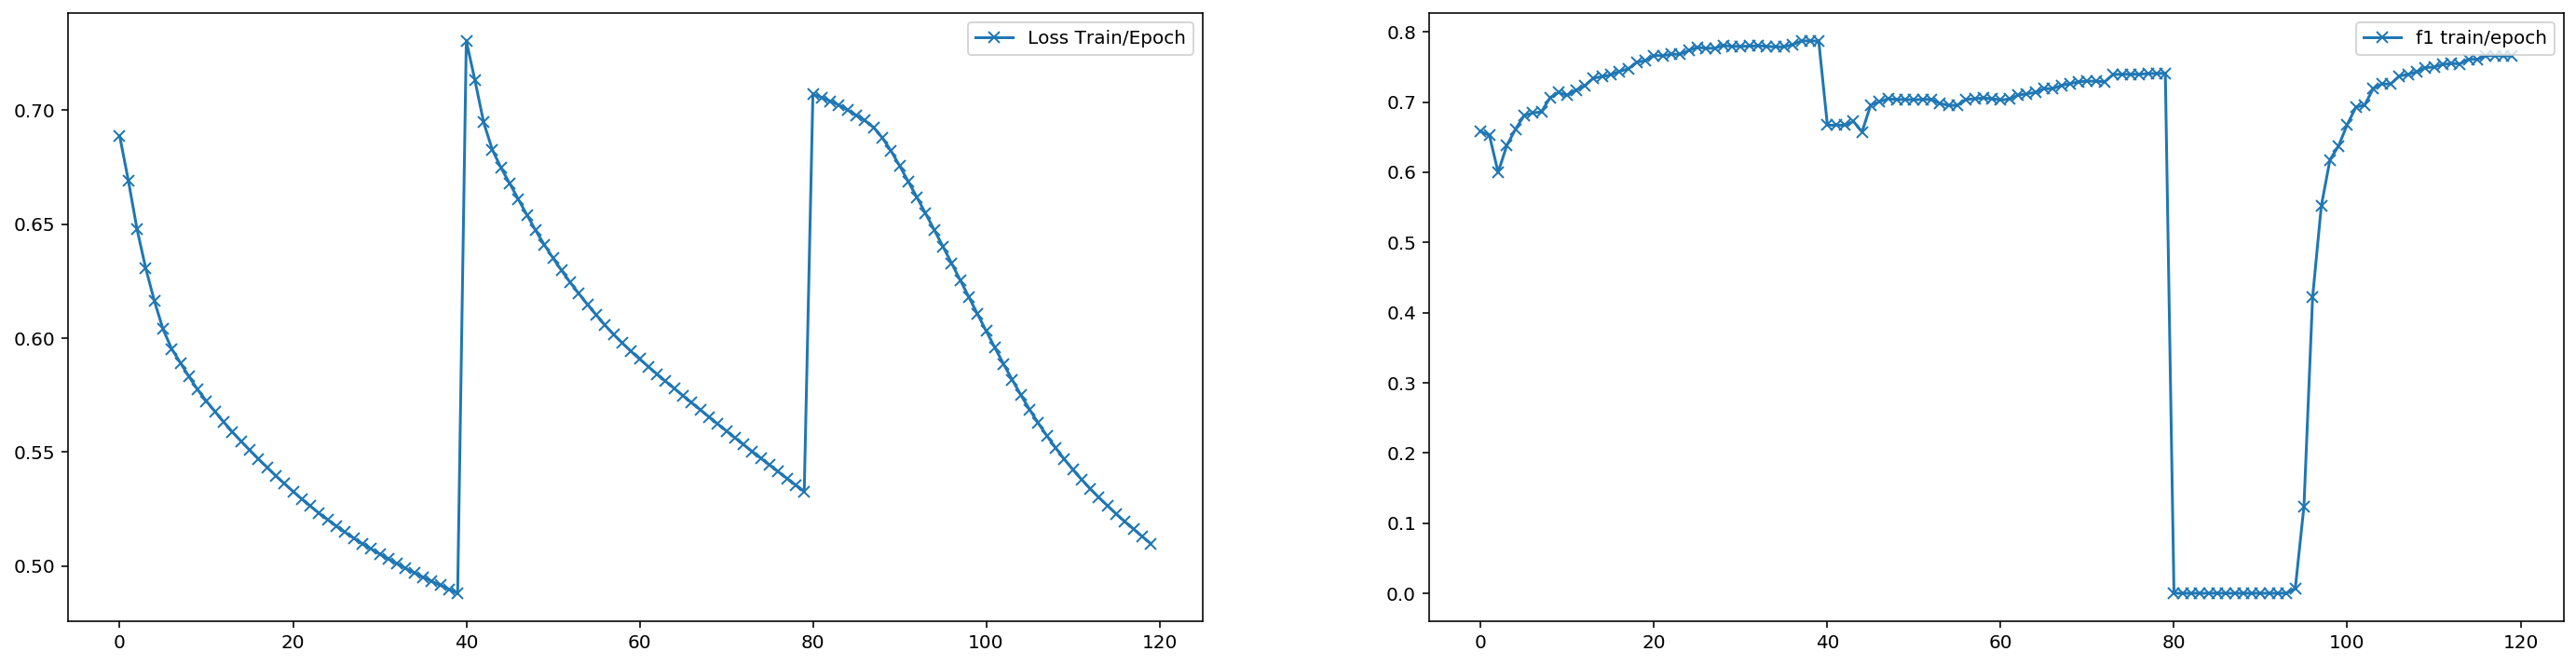

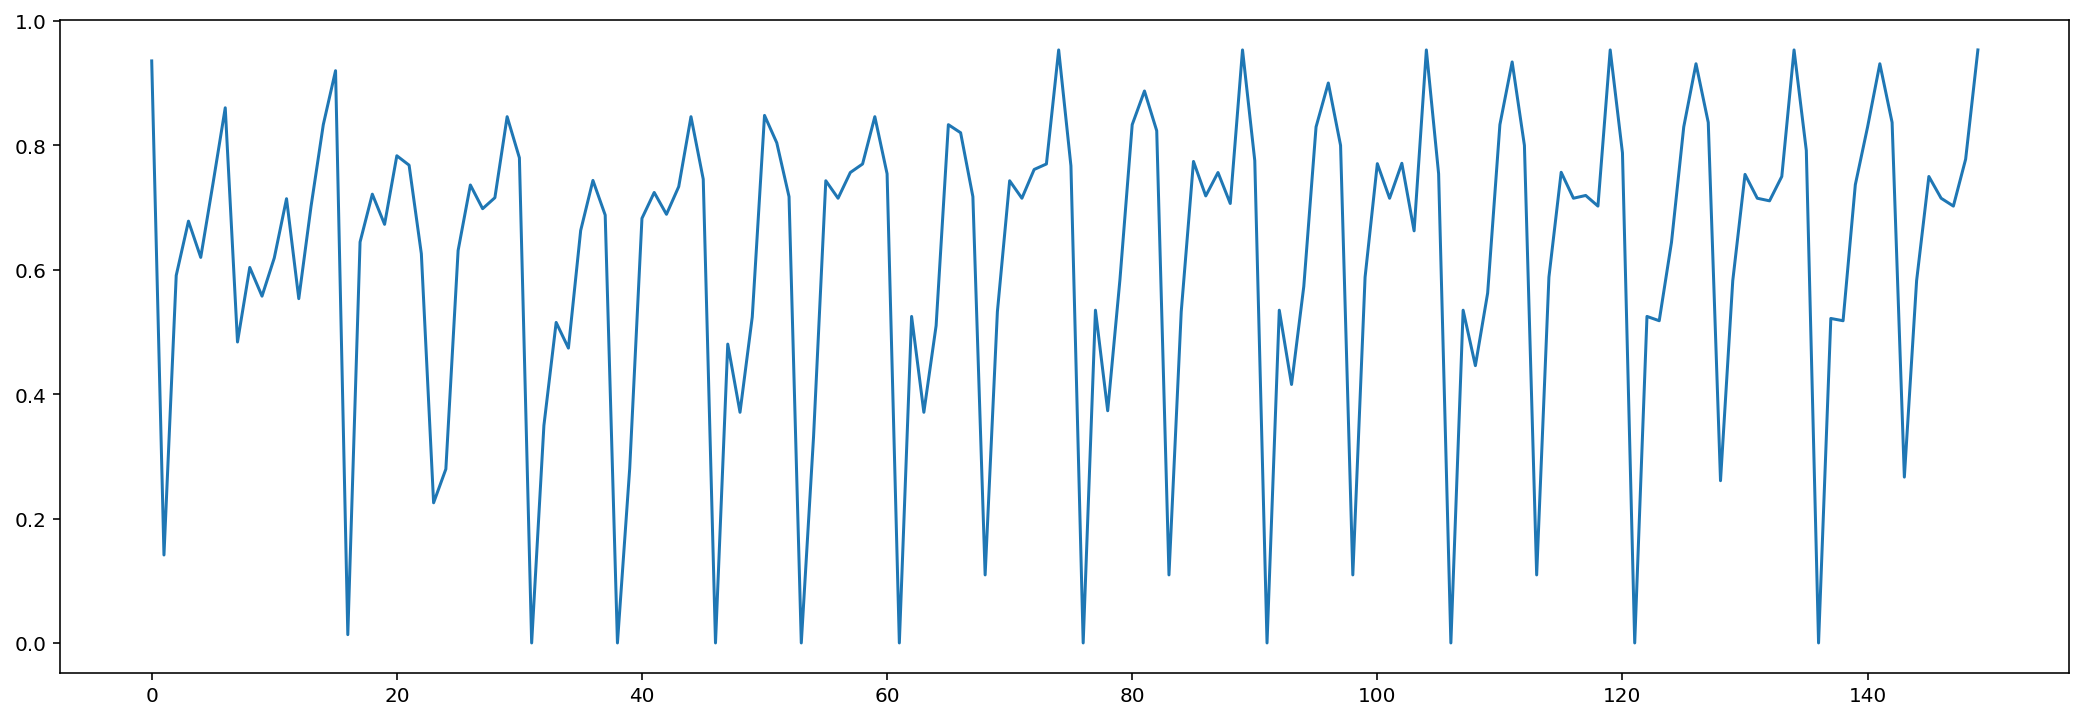

In [30]:
# tracking the CNN's learning
num_of_batches = math.ceil(X_train.shape[0]/b_size)
# plotting loss for training over both epochs and the batches 
epoches = np.arange(0,number_of_epoch*kfolds)
batches =np.arange(0,number_of_epoch*num_of_batches)

fig = plt.figure(figsize=(24,6)) 
ax1 = fig.add_subplot(1,2, 1)
ax1.plot(epoches, av_losses_epoch_train, 'x-',label='Loss Train/Epoch')
ax1.legend(loc='best')
#plt.savefig('/rds/general/user/vu116/home/Blocking/New_idices_daily_mean/images/Loss_plots_' + name + note + date_today + '.png' )

ax2 = fig.add_subplot(1,2, 2) 
ax2.plot(epoches[:], f1_epoch_train[:], 'x-',label='f1 train/epoch')
ax2.legend(loc='best')
#plt.savefig('/rds/general/user/vu116/home/Blocking/New_idices_daily_mean/images/Loss_plots_' + name + note + date_today + '.png' )
plt.show()

plt.figure(figsize=(18,6))
plt.plot(batches[:150], f1_batch[:150])

## Saving CNN's Output and Tracking its Performance 

The following cell is for record keeping. This requires a csv file called *Results\_table\_ddmmyy* that we loaded as `performance_analysis` dataframe  in **Loading data** section. This cell automatically rewrites the table and appends the most recent run of the algorithm to the bottom of the table. Some arguments can be edited, such as note argument and the number of convolutional, maxpool and linear layers.

In [93]:
# write the extra comments of algorith performance
#CHECK the file name used is the correct one 
print ('File used: ' + name)
print ('Labeling used: ' + label)

if min_upsampling:
    if window_method:
        note = 'Z500*,Minority_upscaled,res1X1,corrected windowing,no Shuffling, X-validation'
    else:
        note = 'Z500*,Minority_upscaled,res1X1'
elif maj_downsampling:
    if window_method:
        note = 'Z500*,Majority_downscaled,res1X1,corrected windowing'
    else:
        note = 'Z500*,Majority_downscaled,res1X1'
   

# Run to save new output 
performance_analysis = performance_analysis.append({ 'Time' : datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                                                    'Epoch #': number_of_epoch, 'Batch size' : b_size,
                                                    'Conv, MaxPool, Linear lay#' : str((2,2,2)),
                                                    'f1_score' : f1_cross_vals, 'Raw accuracy': raw_accuracy_X_val,
                                                    'Blocked accuracy' : accuracy_X_val,
                                                    'Pred_Block_Test' : predicted_blocked_days,
                                                    'Actual_Block_Test' : Y_test.sum(),
                                                    'Overprediction' : Overpred_X_val,
                                                    'Extra notes' : note,
                                                    'Learning rate' : lern_rate,
                                                    'Momentum' : mom,
                                                    'Masked' : ismasked,
                                                    'Labeling used' : label,
                                                    'Train, Test size' : '({},{})'.format(X_train.shape[0],X_test.shape[0]),
                                                    'Lat,Lon' : str((X_train.shape[2],X_train.shape[3])),
                                                    'f1_X_val_average' : round(np.mean(f1_cross_vals),4),
                                                    'f1_values' : f1_cross_vals},
                                                    ignore_index=True)

performance_analysis.to_csv('Results_tables/Results_table_' + date_today, index=False)

In [14]:
performance_analysis.tail(10)

,Time,Epoch #,Batch size,f1_score,Raw accuracy,Blocked accuracy,Extra notes,Momentum,Learning rate,Masked,Labeling used,"Train, Test size","Lat,Lon","Conv, MaxPool, Linear lay#",Pred_Block_Test,Actual_Block_Test,Overprediction,f1_X_val_average,f1_values
170,2020-04-17 17:12:28,40,200,"[0.7156, 0.7448, 0.6183]","[0.7008, 0.7272, 0.6778]","[0.7863, 0.8314, 0.5451]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[824.0, 848.0, 525.0]",688.0,"[1.1977, 1.2326, 0.7631]",0.6929,"[0.7156, 0.7448, 0.6183]"
171,2020-04-17 17:17:03,40,200,"[0.698, 0.7382, 0.0]","[0.7008, 0.7251, 0.5087]","[0.704, 0.789, 0.0]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[718.0, 803.0, 0.0]",706.0,"[1.017, 1.1374, 0.0]",0.4787,"[0.698, 0.7382, 0.0]"
172,2020-04-17 17:21:27,40,200,"[0.7652, 0.7154, 0.6441]","[0.7467, 0.7126, 0.6778]","[0.8619, 0.7544, 0.609]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[862.0, 763.0, 613.0]",688.0,"[1.2529, 1.109, 0.891]",0.7082,"[0.7652, 0.7154, 0.6441]"
173,2020-04-17 17:25:45,40,200,"[0.714, 0.6926, 0.6564]","[0.7223, 0.7091, 0.675]","[0.6946, 0.6569, 0.622]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[678.0, 643.0, 642.0]",717.0,"[0.9456, 0.8968, 0.8954]",0.6877,"[0.714, 0.6926, 0.6564]"
174,2020-04-17 17:30:08,40,200,"[0.6589, 0.7077, 0.6589]","[0.4913, 0.7029, 0.4913]","[1.0, 0.7323, 1.0]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[1437.0, 755.0, 1437.0]",706.0,"[2.0354, 1.0694, 2.0354]",0.6752,"[0.6589, 0.7077, 0.6589]"
175,2020-04-17 17:34:36,40,200,"[0.7417, 0.6475, 0.6508]","[0.746, 0.4788, 0.6416]","[0.7616, 1.0, 0.6977]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[725.0, 1437.0, 787.0]",688.0,"[1.0538, 2.0887, 1.1439]",0.6800,"[0.7417, 0.6475, 0.6508]"
176,2020-04-17 17:39:04,40,200,"[0.7633, 0.7241, 0.6653]","[0.7592, 0.6966, 0.6646]","[0.811, 0.8314, 0.6962]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[774.0, 892.0, 752.0]",688.0,"[1.125, 1.2965, 1.093]",0.7176,"[0.7633, 0.7241, 0.6653]"
177,2020-04-17 17:43:26,40,200,"[0.7059, 0.7292, 0.7426]","[0.7112, 0.7105, 0.7265]","[0.7238, 0.814, 0.8241]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[723.0, 848.0, 839.0]",688.0,"[1.0509, 1.2326, 1.2195]",0.7259,"[0.7059, 0.7292, 0.7426]"
178,2020-04-17 17:47:55,40,200,"[0.7427, 0.6605, 0.5709]","[0.7363, 0.6945, 0.6507]","[0.7951, 0.6206, 0.4855]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[785.0, 605.0, 482.0]",688.0,"[1.141, 0.8794, 0.7006]",0.6580,"[0.7427, 0.6605, 0.5709]"
179,2020-04-17 17:52:20,40,200,"[0.6475, 0.7046, 0.6582]","[0.4788, 0.7112, 0.6799]","[1.0, 0.7195, 0.6439]","Z500*,Minority_upscaled,res1X1,corrected windo...",0.95,0.0001,False,GTD_filtered,"(4311,1437)","(46, 357)","(2, 2, 2)","[1437.0, 717.0, 658.0]",688.0,"[2.0887, 1.0422, 0.9564]",0.6701,"[0.6475, 0.7046, 0.6582]"


## Code for Multiple-Run of of the Algorithm with X-Validation

The cell below contains the same code as above but combined into one cell for multiple algorithm runing. If this cell is run, 10 full runs of the algorithm will be performed. Running the algorithm in this cell ensures that **the resampling that is performed is kept constant over all 10 runs**. This is important to obtain a valid algorithm performance estimate as described in the report. A shematic of a full run is shown below. At the bottom of this cell you will find the saved outpu data for the wanted number of full runs, it will automatically be saved into the directory of this notebook. **NOTE:** This code will automaticaly rewrite the Resutls_table file saving it with today's date. Due to scope of the tasks covered in this cell the runtime can vary from an hour to a couple of hours (particularly on slow computers). `tqdm` and `%%time` functions have been implemented for tracking the cells run-time.
<img src="flow_chart.png">

In [ ]:
%%time
# define lists of parameters over which we want to X-cross validate out model
kfolds_many = [2,3,4,5,6,7,8,9,10,11]
batch_sizes = [100,200,250,350,500,750,1000,1200]
epoches = [1000]
learning_rate = [0.01,0.000000001]

#define basic parameters
number_of_full_runs = 10

#parameters for preprocesing
number_classes = 2
window_method = True
window_period = 7
label_day = 4
#choose whether to upsample minority class or downsample majority class
min_upsampling = True
#change to True if masked file is used (line above)
ismasked = False
label = 'GTD_filtered'

#Cross validation and hyper-parameters
kfolds = 3 # Number of K-fold Splits
b_size = 200
number_of_epoch = 40
size_of_test_set = 0.25 (as a fraction of the main dataset)

#dynamic hyper-parameters
lern_rate = 0.0001
mom = 0.95
#uncomment them in the code below if you want to be able to vary them on the fly

dates_and_indices = pd.DataFrame()

f1_test_10runs = []
f1_valid_10runs = []

over_prediction_10runs = []
predicted_labels_10runs = []
validation_predicted_labels_10runs = []

actual_accuracy_10runs = []
blocked_accuracy_10runs = []

number_of_matching_blocked = []
number_of_total_matching_labels = []
number_of_actually_blocked_days = []
number_of_predicted_blocked_days = []

# set the number of full runs youd like to perform 
#this loop can also be changed to perform X-validation of a parameter
# e.g. replace with:
""" for i in batch_size:""" 
# dont forget to replace the parameter for batch size in the code with i
for times in tqdm(range(number_of_full_runs)):

    dates = np.array(file_name[:time_domain_size].time)

    #stacking 5 days together and using it as one training example
    #if not used set window_methode = False
    #if file_name is longer than 3680, need to slice array 
    #need to remove 4 (or however many days we deside to window for )
    file_split = np.array(file_name[:time_domain_size]).reshape(years,days_per_year,file_name.shape[1],file_name.shape[2])
    persistency_applied =[]
    for i in range(len(file_split)):
        persistency_applied.append(windowing_geopotential_new(file_split[i],window_period))

    #need to recise our labeling if window method is used (lose 4 days at the beginning)
    if window_method:
        file_name_ = np.array(persistency_applied).reshape(file_split.shape[0]*(file_split.shape[1]-(window_period-1)),
                                                           file_split.shape[2],file_split.shape[3]*window_period)
        combined_ = format_labeling(GTD[:time_domain_size],window_period,label_day,years, days_per_year)
        formated_dates = format_labeling(dates, window_period,label_day,years,days_per_year)

    # this is for when we have more than one snapshot in a day
    #this does not yet work with windowing 
    if name == '500zg_JJA_era5_1979-2019_3hr_1x1_':
        cut = time_domain_size*(24/3) # for the number of snapshots in 24 hrs period
        multiplier = 8
        dimlat = 41
        dimlon = 51
    else:
        cut = time_domain_size
        multiplier = 1
        dimlat = 181
        dimlon = 201

    #splitting the blocked and non blocked cases for data upsampling
    # first need to combine the labels and the feature data
    full_data = pd.DataFrame(file_name_.reshape(file_name_.shape[0],file_name_.shape[1]*file_name_.shape[2]))
    full_data['label'] = combined_.astype(int)
    full_data['date'] = formated_dates
    full_data['date'] = full_data['date'].dt.date

    #splitting into majority and minority classes
    data_minority = full_data[full_data['label']==1]
    data_majority = full_data[full_data['label']==0]

    if min_upsampling:
        data_minority_upsampled = resample(data_minority, replace = True, n_samples = len(data_majority))
        data_upsampled = pd.concat([data_majority,data_minority_upsampled]).sort_index(axis = 0)
    else:
        data_majority_downsampled = resample(data_majority, replace = True, n_samples = len(data_minority),\
                                             random_state = 123)
        data_upsampled = pd.concat([data_minority, data_majority_downsampled]).sort_index(axis = 0)

    #split it back to features and labels , scaling features
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()

    upsampled_X = sc.fit_transform(data_upsampled.iloc[:,:-2])
    upsampled_Y = np.array(data_upsampled.iloc[:,-2])
    dates_upsampled = data_upsampled.iloc[:,-1]
    
    dates_used = pd.DataFrame(dates_upsampled)
    dates_and_indices['index_iteration_' + str(times)] = dates_used.index
    dates_and_indices['dates_iteration_' + str(times)] = np.array(dates_used['date'])
    
    # saves the dates of labels and contour used for training 
    if maj_downsampling:
        dates_and_indices.to_csv("dates_used_majority_downsampled_10runs_7day_window " + date_today, index=False)
    else:
        dates_and_indices.to_csv("dates_used_minority_upsampled_10runs_" + str(window_period) + "day_window_" 
                                 + name + date_today, index=False)


    # making a dataset (need to reshape the array so it fits the PyTorch requirments)
    X = upsampled_X.reshape(len(upsampled_X), 1, file_name_.shape[1], file_name_.shape[2])
    Y = upsampled_Y 

    # split into train and test 
    X_train, X_test = train_test_split(X,test_size=size_of_test_set,shuffle=False)
    Y_train, Y_test = train_test_split(Y,test_size=size_of_test_set,shuffle=False)
    dates_train, dates_test = train_test_split(dates_upsampled,test_size=size_of_test_set,shuffle=False)
    test_dates = dates_test.reset_index()['date']

    splits = list(StratifiedKFold(n_splits=kfolds, shuffle=False).split(X_train, Y_train))
    x_test_cuda = torch.tensor(X_test, dtype=torch.float)
    test = torch.utils.data.TensorDataset(x_test_cuda)
    test_loader = torch.utils.data.DataLoader(test, batch_size=b_size, shuffle=False)

    f1_cross_vals =[]
    f1_fold_train = []
    f1_fold_valid = []
    f1_epoch_train = []
    av_losses_epoch_train = []
    av_losses_fold_valid = []
    running_losses_epoch_train = []
    running_losses_fold_valid = []
    f1_batch = []
    f1_batch_valid =[]
    
    total_matching_blocked_days = []
    total_actually_blocked_days = []
    matching_outputs = []
    
    predicted_blocked_days =[]
    accuracy_X_val = []
    raw_accuracy_X_val = []
    Overpred_X_val = []

    for i, (train_idx, valid_idx) in enumerate(splits):
        
        x_train = np.array(X_train)
        y_train = np.array(Y_train)

        x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.float)
        y_train_fold = torch.tensor(y_train[train_idx.astype(int)],dtype=torch.float32)

        x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.float)
        y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32)

        # build model and parameters
        bnet = Blocking_Net(class_no=number_classes,)
        #lern_rate = 0.0001
        #mom = 0.95

        # loss function and optimiser
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(bnet.parameters(), lr=lern_rate, momentum=mom)

        #define per fold
        total_pred_test = []

        train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

        train_loader = torch.utils.data.DataLoader(train, batch_size=b_size, shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid, batch_size=b_size, shuffle=False)

        print ("Fold: {}".format(i+1))
        for epoch in range(number_of_epoch):  # loop over the dataset multiple times
            start_time = time.time()
            bnet.train()

            running_loss_train = 0.0
            aver_running_loss_train = 0.0

            #tracking predictions on training datasets and the labels per epoch
            total_pred_train = []
            total_labels_train = []
            total_pred_valid = []
            total_labels_valid = []
            loss_batch =[]

            for i, (x_batch, y_batch) in enumerate(train_loader): # i is the batch number
                outputs = bnet(x_batch) #y_pred

                loss = criterion(outputs, torch.squeeze(y_batch.type(torch.LongTensor)))
                loss_batch.append(loss)

                # zero the parameter gradients
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()           

                pred_train = outputs.data.max(1)[1]

                f1_batch.append(f1_score(np.array(pred_train),np.array(y_batch)))
                total_pred_train = np.concatenate((total_pred_train,np.array(pred_train)), axis=None)
                total_labels_train = np.concatenate((total_labels_train, np.array(y_batch)), axis=None)

                # calculating loss
                running_loss_train += loss.item()
                aver_running_loss_train += loss.item()/len(train_loader)
                
            elapsed_time = time.time() - start_time
            print ('Epoch %d/%2d \t av_loss=%.3f \t loss=%.3f \t f1 score=%.3f \t time=%.2f s' 
                   %(epoch+1, number_of_epoch, aver_running_loss_train,running_loss_train,
                     f1_score(np.array(total_labels_train),np.array(total_pred_train)), elapsed_time)) 
            
            #f1 score and loss of the whole train set per epoch
            f1_epoch_train.append(f1_score(total_pred_train,total_labels_train))        
            running_losses_epoch_train.append(running_loss_train)
            av_losses_epoch_train.append(aver_running_loss_train)

        # now evaluate your model for every fold
        bnet.eval()

        running_loss_valid = 0.0
        aver_running_loss_valid = 0.0
        
        # validation set testing
        for j, (x_batch_valid, y_batch_valid) in enumerate(valid_loader):
            outputs_v = bnet(x_batch_valid).detach()
            
            #validation loss
            loss_val = criterion(outputs_v, torch.squeeze(y_batch_valid.type(torch.LongTensor)))
            aver_running_loss_valid += (loss_val.item()/len(valid_loader))
            
            pred_valid = outputs_v.data.max(1)[1]  
            #f1 scores and combining all batches into 1 full array of pred labels
            f1_batch_valid.append(f1_score(np.array(pred_valid),np.array(y_batch_valid)))
            total_pred_valid = np.concatenate((total_pred_valid,np.array(pred_valid)), axis=None)
            total_labels_valid = np.concatenate((total_labels_valid, np.array(y_batch_valid)), axis=None)

        f1_fold_valid.append(f1_score(total_pred_valid,total_labels_valid))
        validation_predicted_labels_10runs.append(np.array(total_labels_valid))
        av_losses_fold_valid.append(aver_running_loss_valid)   
        running_losses_fold_valid.append(running_loss_valid)

        #test set prediction
        for i, (x_batch,) in enumerate(test_loader):
            net_out = bnet(x_batch).detach()
            
            pred_test = net_out.data.max(1)[1]
            
            total_pred_test = np.concatenate((total_pred_test,np.array(pred_test)), axis=None)

        print('Saving the outputs:')    

        f1_cross_vals.append(round(f1_score(total_pred_test, Y_test),4))
        correct_fold = ((total_pred_test == Y_test)*1).sum()
        blocked_fold,total_fold, accuracy_blocked_fold = check_blocking_accuracy(total_pred_test,Y_test)
        
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format( correct_fold, len(Y_test), 100. * correct_fold / len(Y_test)))
        print ('Sum of predicted blocking events on test data set: {}'.format(np.array(total_pred_test.sum())))

        
        print('Total Matching Blocked Days : {}, Actually Blcoked Days: {}'.format(blocked_fold,total_fold))
        print('Blocked Accuracy: {:.3f}, F1_score Accuracy: {:.3f}'.format(accuracy_blocked_fold,round(f1_score(total_pred_test, Y_test),4)))
        
    
        total_matching_blocked_days.append(blocked_fold) #number of total matching blocked days
        predicted_blocked_days.append(total_pred_test.sum()) #number of predicted blocked days
        total_actually_blocked_days.append(total_fold) #number of actual blocked days
        
        accuracy_X_val.append(round(accuracy_blocked_fold,4)) #blocked accuracy
        matching_outputs.append(correct_fold) #number of matching labels for raw accuracy
        
        Overpred_X_val.append(round(total_pred_test.sum()/Y_test.sum(),4))
        raw_accuracy_X_val.append(round(correct_fold/len(Y_test),4))
        
        predicted_labels_10runs.append(np.array(total_pred_test))
        
    if min_upsampling:
        if window_method:
            note = 'Z500*,' + str(window_period) + '-day window'
        else:
            note = 'Z500*,Minority_upscaled,res1X1'
    elif maj_downsampling:
        if window_method:
            note = 'Z500*,Majority_downscaled,res1X1,corrected windowing'
        else:
            note = 'Z500*,Majority_downscaled,res1X1'
   

    # Run to save new output 
    performance_analysis = performance_analysis.append({ 'Time' : datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                                                    'Epoch #': number_of_epoch, 'Batch size' : b_size,
                                                    'Conv, MaxPool, Linear lay#' : str((2,2,2)),
                                                    'f1_score' : f1_cross_vals, 'Raw accuracy': raw_accuracy_X_val,
                                                    'Blocked accuracy' : accuracy_X_val,
                                                    'Pred_Block_Test' : predicted_blocked_days,
                                                    'Actual_Block_Test' : Y_test.sum(),
                                                    'Overprediction' : Overpred_X_val,
                                                    'Extra notes' : note,
                                                    'Learning rate' : lern_rate,
                                                    'Momentum' : mom,
                                                    'Masked' : ismasked,
                                                    'Labeling used' : label,
                                                    'Train, Test size' : '({},{})'.format(X_train.shape[0],X_test.shape[0]),
                                                    'Lat,Lon' : str((X_train.shape[2],X_train.shape[3])),
                                                    'f1_X_val_average' : round(np.mean(f1_cross_vals),4),
                                                    'f1_values' : f1_cross_vals},
                                                    ignore_index=True)

    #saves most recent run
    performance_analysis.to_csv('Results_table_' + date_today, index=False)
        
    number_of_matching_blocked.append(total_matching_blocked_days)
    number_of_total_matching_labels.append(matching_outputs)
    number_of_actually_blocked_days.append(total_actually_blocked_days)
    number_of_predicted_blocked_days.append(np.array(predicted_blocked_days))
    
    over_prediction_10runs.append(Overpred_X_val)
    actual_accuracy_10runs.append(raw_accuracy_X_val)
    blocked_accuracy_10runs.append(accuracy_X_val)
    f1_test_10runs.append(f1_cross_vals)
    f1_valid_10runs.append(f1_fold_valid)
    
#saving progress, the two most important outputs are: predicted_labels for test and valid 
#the rest could be commented out if not specificly required
if maj_downsampling:
    np.savetxt("predicted_labels_for_10_runs_7day_windows_majority_downsampled",np.array(predicted_labels_10runs))
    np.savetxt("predicted_labels_valid_for_10_runs_7day_windows_majority_downsampled",np.array(validation_predicted_labels_10runs))
    np.savetxt("number_of_matching_blocked_days_majority_downsampled", np.array(number_of_matching_blocked))
    np.savetxt("total_number_of_matching_labels_majority_downsampled",np.array(number_of_total_matching_labels))
    np.savetxt("number_of_actually_blocked_days_majority_downscaled",np.array(number_of_actually_blocked_days))
    np.savetxt("number_of_predicted_blcoked_days_majority_downscaled",np.array(number_of_predicted_blocked_days))
else:
    np.savetxt("predicted_labels_for_10_runs_" + str(window_period) + "day_windows_minority_upsampled_"+name,np.array(predicted_labels_10runs))
    np.savetxt("number_of_matching_blocked_days_minority_upsampled_" + str(window_period) + "day_window_"+name, np.array(number_of_matching_blocked))
    np.savetxt("total_number_of_matching_labels_minority_upsampled_" + str(window_period) + "day_window_"+name,np.array(number_of_total_matching_labels))
    np.savetxt("number_of_actually_blocked_days_minority_upscaled_" + str(window_period) + "day_window"+name,np.array(number_of_actually_blocked_days))
    np.savetxt("number_of_predicted_blcoked_days_minority_upscaled_" + str(window_period) + "day_window"+name,np.array(number_of_predicted_blocked_days))
    np.savetxt("predicted_labels_valid_for_10_runs_" + str(window_period) + "day_windows_minority_upsampled_"+name,np.array(validation_predicted_labels_10runs))
